In [20]:


#!jupyter nbconvert --to html  ASE23.ipynb  --no-input --output-dir=./results/
# --to pdf, html, latex 



[NbConvertApp] Converting notebook ASE23.ipynb to html
[NbConvertApp] Writing 851904 bytes to results\ASE23.html


In [3]:


import json
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'unfr','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3', 's4']  
algorithms = ['GRASP','nsgaii','umda', 'pbil','mimic','geneticnds']  #'geneticnds', 'umda', 'pbil','mimic','nsgaii' 'GRASP'
time_limit = 1000000 # 150 (100000 is no limit)
use_best_config_in_all_datasets = True # True (original) uses the config which worked best among all datasets. False uses the best config for each dataset (and thus time_limit is respected)
values_sss = [True] # si es con los dos: [False, True]

# plots configuration
plots_type_scatter=False # True for scatter of pareto solutions, and False for joint solutions with thick lines
allParetos =False; # plot the 30 paretos, or only 1


files_container = '../output/files_list_allGRASP_Dgeneticnds-umda-pbil-mimic-nsgaii-GRASP'




## 1 Datasets

In [4]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI', '#(PBI-->[PBI])', '%(PBI-->[PBI])','Avg_len[PBI]'])

for name in datasets_names:
    
    ds = Dataset(source_file='../datasets/'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

    n_dependencies = sum(x is not None for x in ds.dependencies)
    ratio_pbi_with_deps =  n_dependencies / n_pbis
    avg_depends_per_pbi = 0
    for dep in ds.dependencies:
        avg_depends_per_pbi = avg_depends_per_pbi + len(dep) if dep is not None else avg_depends_per_pbi + 0
    avg_depends_per_pbi = avg_depends_per_pbi / n_dependencies
    
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis,  '#(PBI-->[PBI])': n_dependencies, '%(PBI-->[PBI])': ratio_pbi_with_deps, 'Avg_len[PBI]':avg_depends_per_pbi}
    new_row = pd.DataFrame(new_row, index=[0])
    ds_summary = pd.concat([ds_summary, new_row], ignore_index=True)

    #ds_summary = ds_summary.append(new_row, ignore_index=True)#deprecated

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)



,Dataset,#Stakeholders,#PBI,#(PBI-->[PBI]),%(PBI-->[PBI]),Avg_len[PBI]
0,p1,5,18,4,0.222,1.750
1,p2,5,96,23,0.240,2.609
2,s1,15,40,17,0.425,1.882
3,s2,50,80,32,0.400,2.250
4,s3,100,140,51,0.364,2.078
5,s4,150,200,72,0.360,2.097


In [5]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    metrics_df = metrics_df[keep_metrics]
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [6]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        time = round((group[1]['time']).loc[max_index],2)
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_time, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_time.extend([time])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_time, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [time], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [7]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, times, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['time'] = times
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [8]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [9]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [10]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2 Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

In [11]:
keep_parameters_random = ['population_length', 'max_generations']
keep_parameters_feda = ['population_length', 'max_generations', 'selection_scheme'] 
keep_parameters_GRASP = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
keep_parameters_geneticnds = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
keep_parameters_umda = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']
keep_parameters_pbil = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']
keep_parameters_mimic = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals','sss_per_iteration']
keep_parameters_nsgaii = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement']

display_drop_feda = ['file','selection_scheme']
display_drop_nsgaii = ['file','selection_candidates','crossover_prob', 'mutation', 'replacement']
display_drop_pbil=['file', 'learning_rate','mutation_prob', 'max_evaluations','mutation_shift']
display_drop_umda=['file', 'replacement_scheme','selection_scheme']
display_drop_random=['file']
display_drop_GRASP=['file']
display_drop_mimic=['file', 'max_evaluations', 'selection_scheme','selected_individuals']
display_drop_geneticnds=['file','selection_candidates','crossover_prob', 'mutation', 'replacement']



for algorithm in algorithms:
    print("-----------------------------------------------------")
    print("SEARCH OF BEST CONFIGURATION FOR: ", algorithm)
    print("-----------------------------------------------------")
   
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    print(datasets_names)
    keep_parameters_alg = globals()['keep_parameters_'+algorithm]
    
    df_alg = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters_alg)
    df_alg = df_alg[df_alg.dataset.isin(datasets_names)]
    if algorithm=='GRASP':
        #get dataframe with df_alg rows where column local_search_type is local_search_bitwise_bestFirst_HV
       
        #df_alg=df_alg[df_alg['local_search_type']=='local_search_bitwise_bestFirst_HV']  #best_first_neighbor_sorted_domination, best_first_neighbor_random_domination, local_search_bitwise_bestFirst_HV
        display(df_alg)
        df_alg=df_alg[df_alg['local_search_type']=='None']
        df_alg=df_alg[df_alg['path_relinking_mode']=='after_local']
        display(df_alg)
        print("Attention: GRASP best config forced to only PR for experiments with best results")
        
    print_hyperparams_values(df_alg, keep_parameters_alg, algorithm)
    #display(df_feda)

   
    globals()['best_config_'+algorithm], best_counts, ndatasets= get_best_configuration(data_df=df_alg, hyperparameters=keep_parameters_alg, metric='HV')
    globals()['best_for_'+algorithm+'_df']=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters_alg, best_counts=best_counts)

    best_for_alg_df =  globals()['best_for_'+algorithm+'_df']
    best_config_alg = globals()['best_config_'+algorithm]
    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    with pd.option_context('display.max_colwidth', None):
        display(best_for_alg_df.drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for ", algorithm," is:")
    for param in best_config_alg:
        print(f"{param}:{best_config_alg[param]}")

    pd.set_option('display.float_format', '{:.3f}'.format)
    display_drop_alg =globals()['display_drop_'+algorithm]
    with pd.option_context('display.max_colwidth', None):
        print((best_for_alg_df.drop(display_drop_alg, axis=1)).to_latex(index=False))

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  GRASP
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']


,dataset,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,HV,spread,unfr,time,nds_update_time,file
0,p1,700,400,stochastically,None,None,True,0.894,0.596,0.231,292.171,143.542,../output/GRASP/GRASPTruep15100True4007000stoc...
1,p1,700,400,stochastically,best_first_neighbor_random,None,True,0.490,0.817,0.250,266.492,26.432,../output/GRASP/GRASPTruep15100True4007000stoc...
2,p1,700,400,stochastically,best_first_neighbor_sorted_score,None,True,0.490,0.820,0.250,261.403,26.501,../output/GRASP/GRASPTruep15100True4007000stoc...
3,p1,700,400,stochastically,best_first_neighbor_sorted_score_r,None,True,0.301,0.939,0.080,545.593,3.632,../output/GRASP/GRASPTruep15100True4007000stoc...
4,p1,700,400,stochastically,best_first_neighbor_random_domination,None,True,0.894,0.608,0.232,365.666,143.624,../output/GRASP/GRASPTruep15100True4007000stoc...
5,p1,700,400,stochastically,best_first_neighbor_sorted_domination,None,True,0.894,0.596,0.231,364.648,144.961,../output/GRASP/GRASPTruep15100True4007000stoc...
6,p1,700,400,stochastically,local_search_bitwise_bestFirst_HV,None,True,0.755,0.658,0.193,3494.653,4.241,../output/GRASP/GRASPTruep15100True4007000stoc...
7,p1,700,400,stochastically,None,after_local,True,0.908,0.532,0.250,757.335,253.411,../output/GRASP/GRASPTruep15100True4007000stoc...
8,p1,700,400,stochastically,best_first_neighbor_random,after_local,True,0.490,0.818,0.250,437.591,53.667,../output/GRASP/GRASPTruep15100True4007000stoc...
9,p1,700,400,stochastically,best_first_neighbor_sorted_score,after_local,True,0.490,0.826,0.250,470.440,57.460,../output/GRASP/GRASPTruep15100True4007000stoc...


,dataset,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,HV,spread,unfr,time,nds_update_time,file
7,p1,700,400,stochastically,None,after_local,True,0.908,0.532,0.250,757.335,253.411,../output/GRASP/GRASPTruep15100True4007000stoc...
21,p2,700,400,stochastically,None,after_local,True,0.857,0.648,0.032,7460.433,699.440,../output/GRASP/GRASPTruep25100True4007000stoc...
35,s1,700,400,stochastically,None,after_local,True,0.869,0.619,0.093,2213.340,619.404,../output/GRASP/GRASPTrues15100True4007000stoc...
49,s2,700,400,stochastically,None,after_local,True,0.789,0.625,0.027,6462.164,970.896,../output/GRASP/GRASPTrues25100True4007000stoc...
63,s3,700,400,stochastically,None,after_local,True,0.843,0.629,0.022,14995.994,840.110,../output/GRASP/GRASPTrues35100True4007000stoc...
77,s4,700,400,stochastically,None,after_local,True,0.814,0.624,0.020,33168.240,1126.349,../output/GRASP/GRASPTrues45100True4007000stoc...


Attention: GRASP best config forced to only PR for experiments with best results
These are the different values used to set hyperparameters in GRASP, for each dataset:
solutions_per_iteration: [700]
iterations: [400]
init_type: ['stochastically']
local_search_type: ['None']
path_relinking_mode: ['after_local']
sss_per_iteration: [ True]
In total, 1 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,time,wins
0,700,400,stochastically,None,after_local,True,"[p1, p2, s1, s2, s3, s4]","[0.9078, 0.8571, 0.8691, 0.7886, 0.8428, 0.8136]","[757.34, 7460.43, 2213.34, 6462.16, 14995.99, 33168.24]",6.000



Best hyperparameter configuration for  GRASP  is:
solutions_per_iteration:700
iterations:400
init_type:stochastically
local_search_type:None
path_relinking_mode:after_local
sss_per_iteration:True
\begin{tabular}{lllllllllr}
\toprule
solutions\_per\_iteration & iterations &      init\_type & local\_search\_type & path\_relinking\_mode & sss\_per\_iteration &                 datasets &                                               HV &                                                    time &  wins \\
\midrule
                    700 &        400 & stochastically &              None &         after\_local &              True & [p1, p2, s1, s2, s3, s4] & [0.9078, 0.8571, 0.8691, 0.7886, 0.8428, 0.8136] & [757.34, 7460.43, 2213.34, 6462.16, 14995.99, 33168.24] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  nsgaii
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These a

,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,datasets,HV,time,wins
0,700,400,2,0.8,0.1,flip1bit,elitism,"[p1, p2, s1, s2, s3, s4]","[0.7811, 0.8173, 0.7341, 0.6303, 0.2538, 0.3839]","[22446.88, 38731.7, 33918.95, 35564.83, 33280.46, 35864.77]",6.000



Best hyperparameter configuration for  nsgaii  is:
population_length:700
max_generations:400
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.1
mutation:flip1bit
replacement:elitism
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & mutation\_prob &                 datasets &                                               HV &                                                        time &  wins \\
\midrule
              700 &             400 &           0.1 & [p1, p2, s1, s2, s3, s4] & [0.7811, 0.8173, 0.7341, 0.6303, 0.2538, 0.3839] & [22446.88, 38731.7, 33918.95, 35564.83, 33280.46, 35864.77] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  umda
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in umda, for each dataset:
population_length: [700]
max_generations: [400]
selection_

,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,time,wins
0,700,400,nds,elitism,True,"[p1, p2, s1, s2, s3, s4]","[0.894, 0.7746, 0.8354, 0.7447, 0.748, 0.7239]","[336.63, 1006.43, 674.64, 1306.62, 1892.57, 1731.56]",6.000



Best hyperparameter configuration for  umda  is:
population_length:700
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                             HV &                                                 time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.894, 0.7746, 0.8354, 0.7447, 0.748, 0.7239] & [336.63, 1006.43, 674.64, 1306.62, 1892.57, 1731.56] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  pbil
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in pbil, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0]
learning_rate: [0.1]
mutati

,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,0.1,0.1,0.1,True,"[p1, p2, s1, s2, s3, s4]","[0.9078, 0.7635, 0.8635, 0.7265, 0.6987, 0.6321]","[209.59, 189.38, 221.29, 266.62, 196.24, 203.89]",6.000



Best hyperparameter configuration for  pbil  is:
population_length:700
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                               HV &                                             time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.9078, 0.7635, 0.8635, 0.7265, 0.6987, 0.6321] & [209.59, 189.38, 221.29, 266.62, 196.24, 203.89] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  mimic
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in mimic, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0]
sele

,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,nds,50,True,"[p1, p2, s1, s2, s3, s4]","[0.7436, 0.7995, 0.8493, 0.7267, 0.7581, 0.723]","[405.75, 2726.68, 1199.21, 2593.09, 2871.16, 1839.38]",6.000



Best hyperparameter configuration for  mimic  is:
population_length:700
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                              HV &                                                  time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.7436, 0.7995, 0.8493, 0.7267, 0.7581, 0.723] & [405.75, 2726.68, 1199.21, 2593.09, 2871.16, 1839.38] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  geneticnds
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in geneticnds, for each dataset:
population_length: [700]
max_generations: [400]
selection_candid

,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,700,400,2,0.8,0.1,flip1bit,elitismnds,True,"[p1, p2, s1, s2, s3, s4]","[0.8858, 0.6892, 0.7606, 0.6643, 0.6539, 0.6229]","[136.44, 272.03, 213.32, 248.39, 310.25, 322.96]",6.000



Best hyperparameter configuration for  geneticnds  is:
population_length:700
max_generations:400
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.1
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True
\begin{tabular}{lllllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration &                 datasets &                                               HV &                                             time &  wins \\
\midrule
              700 &             400 &           0.1 &              True & [p1, p2, s1, s2, s3, s4] & [0.8858, 0.6892, 0.7606, 0.6643, 0.6539, 0.6229] & [136.44, 272.03, 213.32, 248.39, 310.25, 322.96] & 6.000 \\
\bottomrule
\end{tabular}



## 3 Plots of algorithms' NDS with their best configuration

In [12]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files
    
    


In [13]:

def get_files_list_with_best_configuration_per_dataset(alg_name, sss_per_it=False):
    it = values_sss.index(sss_per_it)
    #it = 1 if sss_per_it==True else it
    

    if alg_name=='GRASP':
        df_with_bests = best_for_grasp_df[it]
    if alg_name=='umda':
        df_with_bests = best_for_umda_df[it]
    if alg_name=='pbil':
        df_with_bests = best_for_pbil_df[it]
    if alg_name=='geneticNDS':
        df_with_bests = best_for_geneticnds_df[it]
    if alg_name=='mimic':
        df_with_bests = best_for_mimic_df[it]
    if alg_name=='nsgaii':
        df_with_bests = best_for_nsgaii_df[0] #not done with SSS per it

    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_names:
        try:
            best_conf_row = df_with_bests.loc[df_with_bests['datasets'].apply(lambda x: dataset in x)].iloc[0]
            position = best_conf_row['datasets'].index(dataset)
            file = best_conf_row.file[position]
            algorithm_files.extend([file])
        except: print(f"not best file yet for {dataset} for algorithm {alg_name}")
    
    return algorithm_files
    


In [14]:
import matplotlib as plt
def get_order_xy_points(solutions):
    x = [item[0] for item in solutions]
    y = [1-item[1] for item in solutions] #revert satisfaction. 0,0 is best point
        
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    return x,y
    
    

p1
Pareto Reference has 37 points
Maximum UNFR possible is 10/37=0.2703


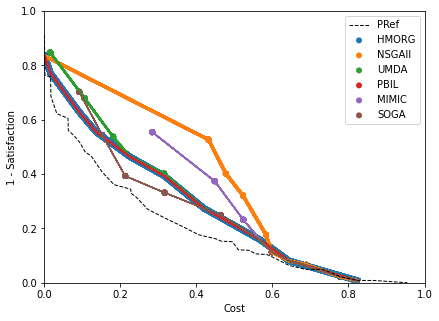

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.9078,0.2500,0.0193,0.5324,757.3354,10.0000
1,nsgaii,0.7811,0.2226,0.0402,0.6756,22446.8824,700.0000
2,umda,0.8940,0.0514,0.0561,0.6506,336.6274,10.0000
3,pbil,0.9078,0.0532,0.0456,0.5345,209.5871,10.0000
4,mimic,0.7436,0.0541,0.0570,0.8260,405.7460,10.0000
5,geneticnds,0.8858,0.0514,0.0508,0.6380,136.4355,10.0000


---------------------------------------------------------------
p2
Pareto Reference has 241 points
Maximum UNFR possible is 10/241=0.0415


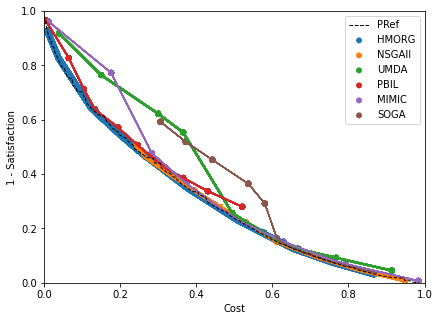

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.8571,0.0319,0.0005,0.6477,7460.4330,10.0000
1,nsgaii,0.8173,0.0195,0.0052,0.6031,38731.6978,573.0667
2,umda,0.7746,0.0028,0.0430,0.6101,1006.4337,10.0000
3,pbil,0.7635,0.0022,0.0184,0.5907,189.3832,10.0000
4,mimic,0.7995,0.0006,0.0193,0.6174,2726.6786,10.0000
5,geneticnds,0.6892,0.0098,0.0577,0.7101,272.0327,10.0000


---------------------------------------------------------------
s1
Pareto Reference has 107 points
Maximum UNFR possible is 10/107=0.0935


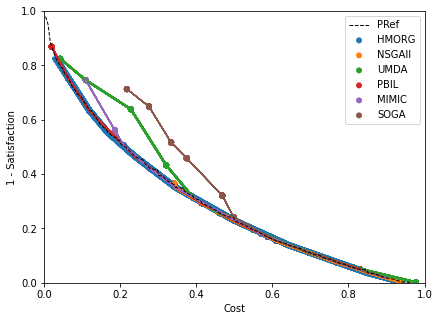

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.8691,0.0935,0.0000,0.6186,2213.3400,10.0000
1,nsgaii,0.7341,0.0869,0.0005,0.6381,33918.9526,700.0000
2,umda,0.8354,0.0477,0.0176,0.6177,674.6405,10.0000
3,pbil,0.8635,0.0816,0.0006,0.6535,221.2865,10.0000
4,mimic,0.8493,0.0735,0.0048,0.5440,1199.2104,10.0000
5,geneticnds,0.7606,0.0411,0.0381,0.6427,213.3205,10.0000


---------------------------------------------------------------
s2
Pareto Reference has 327 points
Maximum UNFR possible is 10/327=0.0306


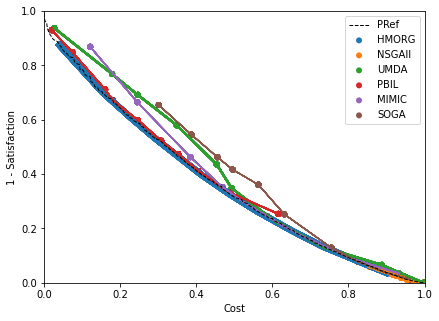

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.7886,0.0270,0.0003,0.6246,6462.1639,10.0000
1,nsgaii,0.6303,0.0170,0.0025,0.6673,35564.8279,639.6000
2,umda,0.7447,0.0082,0.0268,0.5788,1306.6225,10.0000
3,pbil,0.7265,0.0068,0.0075,0.5966,266.6199,10.0000
4,mimic,0.7267,0.0092,0.0144,0.6509,2593.0856,10.0000
5,geneticnds,0.6643,0.0066,0.0396,0.6338,248.3893,10.0000


---------------------------------------------------------------
s3
Pareto Reference has 311 points
Maximum UNFR possible is 10/311=0.0322


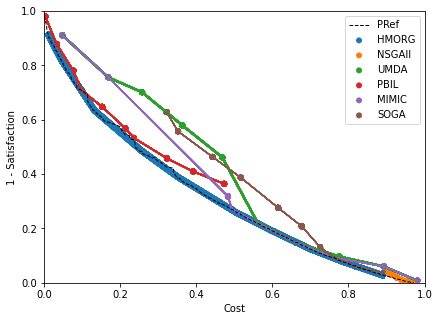

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.8428,0.0217,0.0010,0.6290,14995.9940,10.0000
1,nsgaii,0.2538,0.0184,0.0028,0.9311,33280.4600,700.0000
2,umda,0.7480,0.0040,0.0502,0.6190,1892.5718,10.0000
3,pbil,0.6987,0.0008,0.0277,0.5730,196.2353,10.0000
4,mimic,0.7581,0.0083,0.0277,0.6166,2871.1561,10.0000
5,geneticnds,0.6539,0.0054,0.0656,0.6556,310.2456,10.0000


---------------------------------------------------------------
s4
Pareto Reference has 296 points
Maximum UNFR possible is 10/296=0.0338


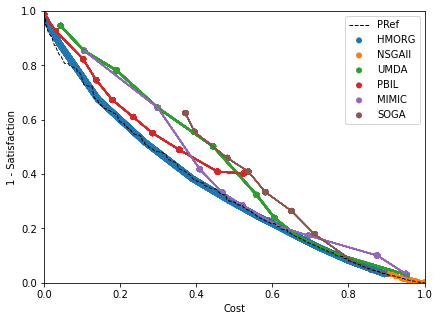

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,GRASP,0.8136,0.0200,0.0017,0.6238,33168.2402,10.0000
1,nsgaii,0.3839,0.0173,0.0036,0.8248,35864.7737,676.2000
2,umda,0.7239,0.0050,0.0475,0.5869,1731.5583,10.0000
3,pbil,0.6321,0.0003,0.0328,0.5703,203.8927,10.0000
4,mimic,0.7230,0.0025,0.0308,0.6421,1839.3813,10.0000
5,geneticnds,0.6229,0.0032,0.0629,0.6593,322.9554,10.0000


---------------------------------------------------------------
       Method     HV  spread   UNFR    time(s)
0       GRASP 0.9078  0.5324 0.2500   757.3354
1      nsgaii 0.7811  0.6756 0.2226 22446.8824
2        umda 0.8940  0.6506 0.0514   336.6274
3        pbil 0.9078  0.5345 0.0532   209.5871
4       mimic 0.7436  0.8260 0.0541   405.7460
5  geneticnds 0.8858  0.6380 0.0514   136.4355
0       GRASP 0.8571  0.6477 0.0319  7460.4330
1      nsgaii 0.8173  0.6031 0.0195 38731.6978
2        umda 0.7746  0.6101 0.0028  1006.4337
3        pbil 0.7635  0.5907 0.0022   189.3832
4       mimic 0.7995  0.6174 0.0006  2726.6786
5  geneticnds 0.6892  0.7101 0.0098   272.0327
0       GRASP 0.8691  0.6186 0.0935  2213.3400
1      nsgaii 0.7341  0.6381 0.0869 33918.9526
2        umda 0.8354  0.6177 0.0477   674.6405
3        pbil 0.8635  0.6535 0.0816   221.2865
4       mimic 0.8493  0.5440 0.0735  1199.2104
5  geneticnds 0.7606  0.6427 0.0411   213.3205
0       GRASP 0.7886  0.6246 0.0270  6462.1

In [15]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


#display(best_for_grasp_df)
files_all_algorithms=[]

if use_best_config_in_all_datasets:
    for alg in algorithms:
        files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration(globals()['best_for_'+alg+'_df'], datasets_names)]


else: #use best config for each dataset in each algorithm
    for alg in algorithms:
        files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration_per_dataset(alg_name=alg)]




wins_counts = {}
wins_counts_unfr = {}
wins_counts_gd = {}
wins_counts_spread = {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
    wins_counts_unfr[alg] = 0
    wins_counts_gd[alg] = 0
    wins_counts_spread[alg] = 0
 

# print 30 (or the number of execution) paretos of each dataset

latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])

#store results for statistical tests
friedman_HV_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] # almacenar HV: algorithmos en filas, datasets en columnas
friedman_unfr_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_gdplus_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_spread_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_nds_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 


for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel(xlabel='Cost')
    ax.set_ylabel(ylabel='1 - Satisfaction')
    print(datasets_names[i])
   # ax.set_title(datasets_names[i])
    plt.xlim(left=0,right=1)
    plt.ylim(bottom=0,top=1)

    
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
            dec=6
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=dec), 'UNFR':np.mean(unfr).round(decimals=dec), 'gd+':np.mean(gdplus).round(decimals=4),
             'spread':np.mean(spread).round(decimals=dec), 'time(s)':np.mean(time).round(decimals=dec), '|NDS|':np.mean(nds).round(decimals=dec)}
            friedman_HV_input[j][i] = new_row['HV']
            friedman_unfr_input[j][i] = new_row['UNFR']
            friedman_gdplus_input[j][i] = new_row['gd+']
            friedman_spread_input[j][i] = new_row['spread']
            friedman_nds_input[j][i] = new_row['|NDS|']
            

            
            for pareto in paretos_list: 
                if allParetos==False:
                    pareto=paretos_list[0]
    
                if plots_type_scatter==False:
                    x,y = get_order_xy_points(pareto)
                    
                    #plt.plot(x,y, linestyle="-", alpha=0.4,linewidth=1, color='C'+str(j),label=algorithms[j])
                    plt.scatter(x,y, alpha=1,edgecolors='none', color='C'+str(j),label=algorithms[j])
                    plt.plot(x,y, linestyle="-", alpha=1,linewidth=len(algorithms)/(j+1), color='C'+str(j),label=algorithms[j])
                else:    
                    x = [item[0] for item in pareto]
                    y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                    plt.scatter(x=x, y=y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                
                    
            
            #summary_df = summary_df.append(new_row, ignore_index=True)
            new_row = pd.DataFrame(new_row, index=[0])
            summary_df = pd.concat([summary_df, new_row], ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts in HV
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # update wins counts in UNFR
    idx_unfr = summary_df['UNFR'].idxmax()
    winner_unfr = summary_df.loc[idx_unfr]['Method']
    wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
    

    # update wins counts in gd+
    idx_gd = summary_df['gd+'].idxmin()
    winner_gd = summary_df.loc[idx_gd]['Method']
    wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


    # update wins counts in spread
    idx_spread = summary_df['spread'].idxmin()
    winner_spread = summary_df.loc[idx_spread]['Method']
    wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    
    #plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='_') 
    x,y = get_order_xy_points(pareto_reference)
    plt.plot(x,y, linestyle="--", linewidth=1, color='black')


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    values = list(by_label.values())
    values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
    legend_keys = by_label.keys()
    legend_keys=[r"SOGA" if s =="geneticnds" else s for s in legend_keys]
    legend_keys=[r"UMDA" if s =="umda" else s for s in legend_keys]
    legend_keys=[r"PBIL" if s =="pbil" else s for s in legend_keys]
    legend_keys=[r"MIMIC" if s =="mimic" else s for s in legend_keys]
    legend_keys=[r"NSGAII" if s =="nsgaii" else s for s in legend_keys]
    legend_keys=[r"HMORG" if s =="GRASP" else s for s in legend_keys]
    legend_keys= ["PRef"] + legend_keys

    plt.legend(values,legend_keys )        
    #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
    


    plt.savefig("imagesASE23/linePareto0_"+datasets_names[i]+".svg")
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    latex_df = pd.concat([latex_df,summary_df])

    

    print("---------------------------------------------------------------")
    

 
#order columns in latex_df to follow this order: Method, HV, spread, UNFR and time(s)
latex_df = latex_df[['Method', 'HV', 'spread', 'UNFR', 'time(s)']]
#latex_df = latex_df.drop(columns=['time(s)'])
print(latex_df)
print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)

print("Wins Counts UNFR:") 
print(wins_counts_unfr)
print("Wins Counts GD+:") 
print(wins_counts_gd)
print("Wins Counts Spread:") 
print(wins_counts_spread)

#print(friedman_HV_input)



## 4 Statistical tests
Group Friedman tests followed, when significant, by pairwise wilcoxon paired test.

In [16]:
#adapated from scikit_posthocs so that we can pass as parameters the alternative, which is greater not two-sided

import itertools as it
import scipy.stats as ss
from statsmodels.sandbox.stats.multicomp import multipletests

def posthoc_wilcoxon(a, val_col=None, group_col=None, zero_method='wilcox', correction=False, p_adjust=None, sort=False, alternative='two-sided'):
    '''Pairwise comparisons with Wilcoxon signed-rank test. It is a non-parametric
    version of the paired T-test for use with non-parametric ANOVA.

    Parameters
    ----------
    a : array_like or pandas DataFrame object
        An array, any object exposing the array interface or a pandas
        DataFrame. Array must be two-dimensional.

    val_col : str, optional
        Name of a DataFrame column that contains dependent variable values (test
        or response variable). Values should have a non-nominal scale. Must be
        specified if `a` is a pandas DataFrame object.

    group_col : str, optional
        Name of a DataFrame column that contains independent variable values
        (grouping or predictor variable). Values should have a nominal scale
        (categorical). Must be specified if `a` is a pandas DataFrame object.

    zero_method : string, {"pratt", "wilcox", "zsplit"}, optional
        "pratt": Pratt treatment, includes zero-differences in the ranking
        process (more conservative)
        "wilcox": Wilcox treatment, discards all zero-differences
        "zsplit": Zero rank split, just like Pratt, but spliting the zero rank
        between positive and negative ones

    correction : bool, optional
        If True, apply continuity correction by adjusting the Wilcoxon rank
        statistic by 0.5 towards the mean value when computing the z-statistic.
        Default is False.

    p_adjust : str, optional
        Method for adjusting p values.
        See statsmodels.sandbox.stats.multicomp for details.
        Available methods are:
        'bonferroni' : one-step correction
        'sidak' : one-step correction
        'holm-sidak' : step-down method using Sidak adjustments
        'holm' : step-down method using Bonferroni adjustments
        'simes-hochberg' : step-up method  (independent)
        'hommel' : closed method based on Simes tests (non-negative)
        'fdr_bh' : Benjamini/Hochberg  (non-negative)
        'fdr_by' : Benjamini/Yekutieli (negative)
        'fdr_tsbh' : two stage fdr correction (non-negative)
        'fdr_tsbky' : two stage fdr correction (non-negative)

    sort : bool, optional
        Specifies whether to sort DataFrame by group_col and val_col or not.
        Default is False.

    Returns
    -------
    result : pandas DataFrame
        P values.

    Notes
    -----
    Refer to `scipy.stats.wilcoxon` reference page for further details.

    Examples
    --------
    >>> x = [[1,2,3,4,5], [35,31,75,40,21], [10,6,9,6,1]]
    >>> sp.posthoc_wilcoxon(x)
    '''

    x, _val_col, _group_col = sp.__convert_to_df(a, val_col, group_col)
    x = x.sort_values(by=[_group_col, _val_col], ascending=True) if sort else x

    groups = x[_group_col].unique()
    x_len = groups.size
    vs = np.zeros((x_len, x_len))
    xg = x.groupby(_group_col)[_val_col]
    tri_upper = np.triu_indices(vs.shape[0], 1)
    tri_lower = np.tril_indices(vs.shape[0], -1)
    vs[:, :] = 0

    combs = it.combinations(range(x_len), 2)

    for i, j in combs:
        vs[i, j] = ss.wilcoxon(
            xg.get_group(groups[i]),
            xg.get_group(groups[j]),
            zero_method=zero_method,
            correction=correction,
            alternative=alternative)[1]

    if p_adjust:
        vs[tri_upper] = multipletests(vs[tri_upper], method=p_adjust)[1]
    vs[tri_lower] = np.transpose(vs)[tri_lower]
    np.fill_diagonal(vs, 1)
    return pd.DataFrame(vs, index=groups, columns=groups)

In [17]:
from scipy import stats
import scikit_posthocs as sp#
import numpy as np
#https://www.statology.org/nemenyi-test-python/
algorithms_x_datasets_values=[]

def friedman(*algorithms_x_datasets_values, metric_name): #algorithms in rows, datasets in columns
    print(metric_name)
    pvalue=stats.friedmanchisquare(*algorithms_x_datasets_values).pvalue

    if(pvalue>0.05):
        print("Friedman test not significant!")
    else:
        # convert the list of lists to a numpy array
        algorithms_x_datasets_values = np.array(algorithms_x_datasets_values)
        
        
        #result = sp.posthoc_mannwhitney(algorithms_x_datasets_values, p_adjust = 'fdr_bh') #alternative='less'
        #result = sp.posthoc_nemenyi_friedman(algorithms_x_datasets_values.T, sort='True') #alternative='less'
        
        #paired Pairwise comparisons with Wilcoxon signed-rank test.
              
        #result = sp.posthoc_wilcoxon(list(algorithms_x_datasets_values),p_adjust='fdr_bh', sort=True) # p_adjust='fdr_bh'
        result = posthoc_wilcoxon(list(algorithms_x_datasets_values),p_adjust='fdr_tsbh', sort=True, alternative='greater') # p_adjust='fdr_bh'
        
        # Set the row and column names of the DataFrame using the algorithm names
        result.index = algorithms
        result.columns = algorithms
        # Highlight cells with values less than 0.05
        highlight = lambda x: 'background-color: green' if x < 0.05 else ''
        styled_result = result.style.applymap(highlight)
        # display the result DataFrame
        display(styled_result)


In [18]:
print(friedman_HV_input)
friedman(*friedman_HV_input, metric_name='HV')

for i in range(len(algorithms)):
    print(algorithms[i],'mean HV=', np.mean(friedman_HV_input[i]))
    

friedman(*friedman_unfr_input,metric_name='UNFR')
for i in range(len(algorithms)):
     print(algorithms[i],'mean UNFR=', np.mean(friedman_unfr_input[i]))

friedman(*friedman_gdplus_input,metric_name='GD+')
for i in range(len(algorithms)):
    print(algorithms[i],'mean GD+=', np.mean(friedman_gdplus_input[i]))

friedman(*friedman_spread_input,metric_name='Spread')


[[0.907767, 0.857143, 0.869127, 0.788641, 0.842827, 0.813607], [0.781088, 0.817302, 0.734091, 0.630277, 0.253817, 0.383947], [0.894031, 0.774644, 0.835407, 0.744746, 0.747999, 0.723887], [0.907804, 0.76353, 0.863466, 0.726539, 0.69872, 0.632077], [0.743595, 0.799517, 0.849345, 0.726703, 0.758119, 0.722952], [0.885762, 0.689225, 0.760606, 0.66426, 0.653932, 0.622856]]
HV


,GRASP,nsgaii,umda,pbil,mimic,geneticnds
GRASP,1.000000,0.017857,0.017857,0.027778,0.017857,0.017857
nsgaii,0.017857,1.000000,0.533333,0.533333,0.533333,0.533333
umda,0.017857,0.533333,1.000000,0.175000,0.017857,0.017857
pbil,0.027778,0.533333,0.175000,1.000000,0.420455,0.017857
mimic,0.017857,0.533333,0.017857,0.420455,1.000000,0.027778
geneticnds,0.017857,0.533333,0.017857,0.017857,0.027778,1.000000


GRASP mean HV= 0.8465186666666668
nsgaii mean HV= 0.600087
umda mean HV= 0.7867856666666667
pbil mean HV= 0.765356
mimic mean HV= 0.7667051666666668
geneticnds mean HV= 0.7127735
UNFR


,GRASP,nsgaii,umda,pbil,mimic,geneticnds
GRASP,1.000000,0.010417,0.010417,0.010417,0.010417,0.010417
nsgaii,0.010417,1.000000,0.010417,0.010417,0.010417,0.010417
umda,0.010417,0.010417,1.000000,0.289062,0.356250,0.346111
pbil,0.010417,0.010417,0.289062,1.000000,0.356250,0.272727
mimic,0.010417,0.010417,0.356250,0.356250,1.000000,0.206250
geneticnds,0.010417,0.010417,0.346111,0.272727,0.206250,1.000000


GRASP mean UNFR= 0.07401949999999999
nsgaii mean UNFR= 0.0636395
umda mean UNFR= 0.019809499999999997
pbil mean UNFR= 0.024150666666666668
mimic mean UNFR= 0.024671833333333334
geneticnds mean UNFR= 0.019571666666666664
GD+


,GRASP,nsgaii,umda,pbil,mimic,geneticnds
GRASP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nsgaii,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
umda,1.000000,1.000000,1.000000,0.234375,0.234375,1.000000
pbil,1.000000,1.000000,0.234375,1.000000,1.000000,1.000000
mimic,1.000000,1.000000,0.234375,1.000000,1.000000,1.000000
geneticnds,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


GRASP mean GD+= 0.003800000000000001
nsgaii mean GD+= 0.009133333333333332
umda mean GD+= 0.04019999999999999
pbil mean GD+= 0.022099999999999998
mimic mean GD+= 0.025666666666666667
geneticnds mean GD+= 0.052450000000000004
Spread
Friedman test not significant!
